# import .csv of nhanes 2015 data

In [25]:
import pandas as pd

df = pd.read_csv("nhanes_full_1516.csv")

df.shape, df.head()


((9971, 471),
       SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
 0  83732.0       9.0       2.0       1.0      62.0       NaN       3.0   
 1  83733.0       9.0       2.0       1.0      53.0       NaN       3.0   
 2  83734.0       9.0       2.0       1.0      78.0       NaN       3.0   
 3  83735.0       9.0       2.0       2.0      56.0       NaN       3.0   
 4  83736.0       9.0       2.0       2.0      42.0       NaN       4.0   
 
    RIDRETH3  RIDEXMON  RIDEXAGM  ...  nuts_seeds  low_fat_dairy  fish  \
 0       3.0       1.0       NaN  ...        0.00           0.00   0.0   
 1       3.0       1.0       NaN  ...        0.00           0.11   0.0   
 2       3.0       2.0       NaN  ...        0.00           0.13   0.0   
 3       3.0       2.0       NaN  ...        0.09           1.66   0.0   
 4       4.0       2.0       NaN  ...        0.00           0.00   0.0   
 
    red_meat  processed_meat  refined_grains   ssb  fried_foods  rpdqs_total  \
 0      

# clean 

In [26]:
# Keep only numeric columns
df_num = df.select_dtypes(include="number")

# Drop SEQN and NHANES survey design variables
drop_cols = [
    "SEQN",        # participant identifier
    "SDMVPSU",     # primary sampling unit
    "SDMVSTRA",    # sampling strata
    "WTINT2YR",    # interview weight
    "WTMEC2YR",    # MEC exam weight
    "WTDRD1",      # dietary day 1 weight
    "WTDR2D"       # dietary 2-day weight
]

df_num = df_num.drop(columns=[c for c in drop_cols if c in df_num.columns])

# Drop columns with >30% missing (adjust threshold as needed)
df_num = df_num.dropna(thresh=0.7 * len(df_num), axis=1)

# Impute remaining missing values with column mean
df_num = df_num.fillna(df_num.mean())

df_num.shape


(9971, 203)

# standardize

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_num)

df_z = pd.DataFrame(X, columns=df_num.columns, index=df_num.index)


# build physiologic systems

In [28]:
physio_systems = {
    "Lipids": [
        "hdl_cholesterol", "total_cholesterol", "triglycerides",
        "LBDLDL", "apob_est"
    ],
    
    "Metabolic": [
        "fasting_glucose", "fasting_insulin", "homa_ir"
    ],
    
    "Blood_Pressure": [
        "sbp", "dbp", "pulse_pressure",
        "BPXSY1", "BPXSY2", "BPXSY3", "BPXSY4",
        "BPXDI1", "BPXDI2", "BPXDI3", "BPXDI4"
    ],
    
    "Renal": [
        "serum_creatinine", "egfr",
        "URXUCR", "URXUMA", "URXUMS"
    ],

    "Liver": [
        "LBXSAL", "LBXSAPSI", "LBXSASSI",
        "LBXSTB", "LBXSTP", "LBXSTR"
    ],

    "Sleep": [
        "sleep_hours", "sleep_score"
    ],

    "Diet_Quality": [
        "rpdqs_total", "rpdqs_normalized"
    ],
    
    "Mental_Health": [
        "DPQ010", "DPQ020", "DPQ030", "DPQ040", "DPQ050",
        "DPQ060", "DPQ070", "DPQ080", "DPQ090", "DPQ100"
    ],
    
    "Demographics": [
        "age", "sex", "race_ethnicity", "poverty_income_ratio"
    ],

    "Physical_Activity": [
        "mvpa_min_week"
    ],

    "Macronutrients": [
        "DR1TCARB", "DR1TPROT", "DR1TTFAT",
        "DR1TSUGR", "DR1TFIBE"
    ]
}


# build correlation matrix

In [29]:
corr = df_num.corr()
corr.head()


,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMDBORN4,DMDCITZN,SIALANG,...,nuts_seeds,low_fat_dairy,fish,red_meat,processed_meat,refined_grains,ssb,fried_foods,rpdqs_total,rpdqs_normalized
SDDSRVYR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RIDSTATR,NaN,1.000000,0.006445,-0.005279,0.009823,0.007669,-3.930148e-16,0.001079,0.014953,-0.000863,...,-2.983161e-16,-8.807147e-17,-3.980711e-16,8.314516e-17,2.383925e-16,1.284281e-16,-2.579530e-16,5.032049e-17,0.050681,0.050681
RIAGENDR,NaN,0.006445,1.000000,0.010926,-0.028654,-0.027166,9.114734e-03,0.017368,0.010049,0.015939,...,-3.558866e-02,-6.382006e-02,-1.112439e-02,-1.121226e-01,-9.870044e-02,-1.422610e-01,-1.083150e-01,-1.288226e-01,0.083028,0.083028
RIDAGEYR,NaN,-0.005279,0.010926,1.000000,0.009406,-0.010016,-5.899654e-02,0.079404,0.073089,0.045033,...,9.110432e-02,-1.435473e-01,8.278687e-02,1.034903e-01,4.346655e-02,-6.436909e-03,1.097166e-01,3.248179e-02,0.029513,0.029513
RIDRETH1,NaN,0.009823,-0.028654,0.009406,1.000000,0.969790,2.062028e-01,-0.008570,-0.094414,-0.489460,...,4.444479e-02,-1.102268e-02,3.223589e-02,-1.394719e-02,1.209630e-02,-8.800509e-02,1.475278e-02,-3.639335e-02,0.047971,0.047971


# build system level composite scores
(mean of system standardized variables)

In [33]:
df_system = pd.DataFrame(index=df_z.index)

for system, vars_ in physio_systems.items():
    valid = [v for v in vars_ if v in df_z.columns]
    if len(valid) == 0:
        continue
    df_system[system] = df_z[valid].mean(axis=1)

df_system.head()


,Lipids,Blood_Pressure,Renal,Diet_Quality,Demographics,Macronutrients
0,-0.399209,0.061757,-0.457988,-1.097212,-0.003543,-0.079254
1,1.504973,1.278785,0.219700,-2.978362,-0.194618,0.249206
2,-0.169458,-0.073517,-0.079278,-0.470162,0.074433,0.725383
3,0.144037,0.599329,-0.176589,0.000126,0.435982,-0.491288
4,0.287273,-0.754920,0.879474,-0.156637,0.393405,-1.242656


# system level correlation network

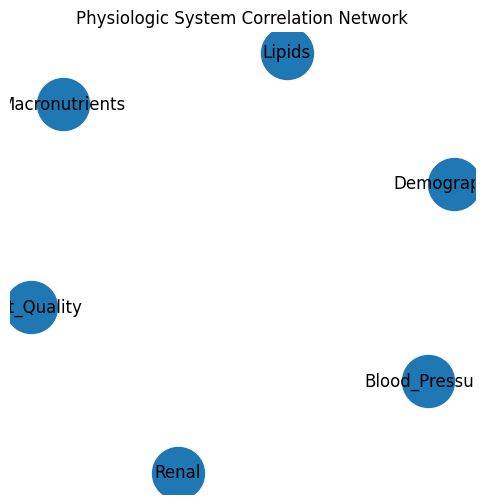

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

corr_sys = df_system.corr()

G_sys = nx.Graph()

for col in corr_sys.columns:
    G_sys.add_node(col)

THRESH = 0.3

for i in corr_sys.columns:
    for j in corr_sys.columns:
        if i >= j:
            continue
        r = corr_sys.loc[i, j]
        if abs(r) > THRESH:
            G_sys.add_edge(i, j, weight=r)

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G_sys, seed=42)

weights = [abs(G_sys[u][v]['weight']) * 3 for u, v in G_sys.edges()]

nx.draw_networkx_nodes(G_sys, pos, node_size=1400)
nx.draw_networkx_labels(G_sys, pos, font_size=12)
nx.draw_networkx_edges(G_sys, pos, width=weights, alpha=0.7)

plt.title("Physiologic System Correlation Network")
plt.axis("off")
plt.show()


# Gaussian graphical model

In [32]:
from sklearn.covariance import GraphicalLassoCV
import numpy as np

X_sys = df_system.values

ggm = GraphicalLassoCV()
ggm.fit(X_sys)

Theta = ggm.precision_
D = np.sqrt(np.diag(Theta))

partial_corr = -Theta / np.outer(D, D)
np.fill_diagonal(partial_corr, 1)

partial_df = pd.DataFrame(
    partial_corr,
    index=df_system.columns,
    columns=df_system.columns
)


# build and plot GGM network

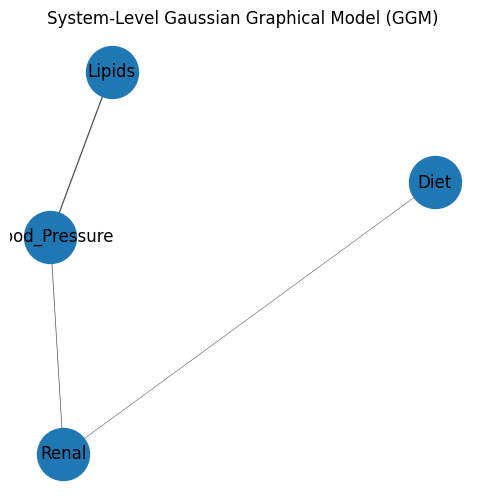

In [19]:
G_ggm = nx.Graph()

names = df_system.columns
THRESH_PCOR = 0.05  # keep only meaningful edges

for i, a in enumerate(names):
    for j, b in enumerate(names):
        if i >= j:
            continue
        if abs(partial_corr[i, j]) > THRESH_PCOR:
            G_ggm.add_edge(a, b, weight=partial_corr[i, j])

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G_ggm, seed=1)

weights = [abs(G_ggm[u][v]['weight'])*6 for u, v in G_ggm.edges()]

nx.draw_networkx_nodes(G_ggm, pos, node_size=1400)
nx.draw_networkx_labels(G_ggm, pos, font_size=12)
nx.draw_networkx_edges(G_ggm, pos, width=weights, alpha=0.7)

plt.title("System-Level Gaussian Graphical Model (GGM)")
plt.axis("off")
plt.show()


# print systems with valid variables

In [34]:
for system, vars_ in physio_systems.items():
    valid = [v for v in vars_ if v in df_z.columns]
    print(f"{system:20s}  valid vars: {len(valid)}")


Lipids                valid vars: 2
Metabolic             valid vars: 0
Blood_Pressure        valid vars: 9
Renal                 valid vars: 3
Liver                 valid vars: 0
Sleep                 valid vars: 0
Diet_Quality          valid vars: 2
Mental_Health         valid vars: 0
Demographics          valid vars: 4
Physical_Activity     valid vars: 0
Macronutrients        valid vars: 5


In [35]:
[x for x in df_num.columns if "glu" in x.lower()]


[]

In [36]:
[x for x in df_num.columns if "ins" in x.lower()]


['whole_grains', 'refined_grains']

In [37]:
[x for x in df_num.columns if "homa" in x.lower()]


[]

In [38]:
[x for x in df_num.columns if "a1c" in x.lower()]


[]

In [39]:
[x for x in df_num.columns if "sleep" in x.lower()]


[]

In [40]:
[x for x in df_num.columns if "slq" in x.lower()]


[]

In [41]:
[x for x in df_num.columns if col.startswith("DPQ")]


[]

In [42]:
[x for x in df_num.columns if "dpq" in x.lower()]


[]

In [43]:
[x for x in df_num.columns if col.startswith("PA")]


[]

In [44]:
[x for x in df_num.columns if "paq" in x.lower()]


['PAQ710', 'PAQ715']

In [45]:
[x for x in df_num.columns if "alt" in x.lower() or "ast" in x.lower() or "ggt" in x.lower()]


[]

In [46]:
[x for x in df_num.columns if "lbxs" in x.lower()]


[]

In [47]:
df_num.columns.tolist()


['SDDSRVYR',
 'RIDSTATR',
 'RIAGENDR',
 'RIDAGEYR',
 'RIDRETH1',
 'RIDRETH3',
 'RIDEXMON',
 'DMDBORN4',
 'DMDCITZN',
 'SIALANG',
 'SIAPROXY',
 'SIAINTRP',
 'FIALANG',
 'FIAPROXY',
 'FIAINTRP',
 'DMDHHSIZ',
 'DMDFMSIZ',
 'DMDHHSZA',
 'DMDHHSZB',
 'DMDHHSZE',
 'DMDHRGND',
 'DMDHRAGE',
 'DMDHRBR4',
 'DMDHREDU',
 'DMDHRMAR',
 'INDHHIN2',
 'INDFMIN2',
 'INDFMPIR',
 'hdl_cholesterol',
 'LBDHDDSI',
 'total_cholesterol',
 'LBDTCSI',
 'DR1DRSTZ',
 'DR1EXMER',
 'DRABF',
 'DRDINT',
 'DR1DBIH',
 'DR1DAY',
 'DR1LANG',
 'DR1MRESP',
 'DR1HELP',
 'DBQ095Z',
 'DRQSPREP',
 'DR1STY',
 'DRQSDIET',
 'DR1TNUMF',
 'DR1TKCAL',
 'DR1TPROT',
 'DR1TCARB',
 'DR1TSUGR',
 'DR1TFIBE',
 'DR1TTFAT',
 'DR1TSFAT',
 'DR1TMFAT',
 'DR1TPFAT',
 'DR1TCHOL',
 'DR1TATOC',
 'DR1TATOA',
 'DR1TRET',
 'DR1TVARA',
 'DR1TACAR',
 'DR1TBCAR',
 'DR1TCRYP',
 'DR1TLYCO',
 'DR1TLZ',
 'DR1TVB1',
 'DR1TVB2',
 'DR1TNIAC',
 'DR1TVB6',
 'DR1TFOLA',
 'DR1TFA',
 'DR1TFF',
 'DR1TFDFE',
 'DR1TCHL',
 'DR1TVB12',
 'DR1TB12A',
 'DR1TVC',
 'DR1TVD',
 

# main import / standardize

In [49]:
# starting point you already ran
df = pd.read_csv("nhanes_full_1516.csv")

df_num = df.select_dtypes(include="number")

drop_cols = ["SEQN", "SDMVPSU", "SDMVSTRA", "WTINT2YR", "WTMEC2YR",
             "WTDRD1", "WTDR2D"]
df_num = df_num.drop(columns=[c for c in drop_cols if c in df_num.columns])

df_num = df_num.dropna(thresh=0.7 * len(df_num), axis=1)
df_num = df_num.fillna(df_num.mean())

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_z = pd.DataFrame(
    scaler.fit_transform(df_num),
    columns=df_num.columns,
    index=df_num.index
)


# define systems using variables we have

In [50]:
physio_systems = {
    # Lipids in conventional units
    "Lipids": [
        "hdl_cholesterol", "total_cholesterol"
    ],
    
    # Clinic + automated BP + derived BP
    "Blood_Pressure": [
        "sbp", "dbp", "pulse_pressure",
        "BPXSY1", "BPXSY2", "BPXSY3",
        "BPXDI1", "BPXDI2", "BPXDI3"
    ],
    
    # Albuminuria / creatinine panel
    "Renal_Albuminuria": [
        "URXUMA", "URDUMALC", "URXUMS",
        "URXUCR", "URDUCRLC", "URXCRS", "URDACT"
    ],
    
    # Basic demographics
    "Demographics": [
        "age", "sex", "race_ethnicity"
    ],
    
    # Socioeconomic status
    "Socioeconomic": [
        "INDHHIN2", "INDFMIN2", "INDFMPIR", "poverty_income_ratio"
    ],
    
    # Self-reported PA (active transport)
    "Physical_Activity": [
        "PAQ710", "PAQ715"
    ],
    
    # Energy + main macronutrients
    "Energy_Macros": [
        "DR1TKCAL", "DR1TPROT", "DR1TCARB",
        "DR1TSUGR", "DR1TFIBE", "DR1TTFAT"
    ],
    
    # Detailed fatty-acid profile
    "Fatty_Acid_Profile": [
        "DR1TSFAT", "DR1TMFAT", "DR1TPFAT",
        "DR1TS040", "DR1TS060", "DR1TS080", "DR1TS100",
        "DR1TS120", "DR1TS140", "DR1TS160", "DR1TS180",
        "DR1TM161", "DR1TM181", "DR1TM201", "DR1TM221",
        "DR1TP182", "DR1TP183", "DR1TP184", "DR1TP204",
        "DR1TP205", "DR1TP225", "DR1TP226"
    ],
    
    # Vitamins & minerals
    "Micronutrients": [
        "DR1TATOC", "DR1TATOA", "DR1TRET", "DR1TVARA", "DR1TACAR",
        "DR1TBCAR", "DR1TCRYP", "DR1TLYCO",
        "DR1TLZ", "DR1TVB1", "DR1TVB2", "DR1TNIAC", "DR1TVB6",
        "DR1TFOLA", "DR1TFA", "DR1TFF", "DR1TFDFE", "DR1TCHL",
        "DR1TVB12", "DR1TB12A", "DR1TVC", "DR1TVD", "DR1TVK",
        "DR1TCALC", "DR1TPHOS", "DR1TMAGN", "DR1TIRON", "DR1TZINC",
        "DR1TCOPP", "DR1TSELE"
    ],
    
    # HEI-style food group servings from 24-hr recall
    "Food_Groups_HEI": [
        "DR1T_F_CITMLB", "DR1T_F_OTHER", "DR1T_F_JUICE", "DR1T_F_TOTAL",
        "DR1T_V_DRKGR", "DR1T_V_REDOR_TOMATO", "DR1T_V_REDOR_OTHER",
        "DR1T_V_REDOR_TOTAL", "DR1T_V_STARCHY_POTATO", "DR1T_V_STARCHY_OTHER",
        "DR1T_V_STARCHY_TOTAL", "DR1T_V_OTHER", "DR1T_V_TOTAL",
        "DR1T_V_LEGUMES",
        "DR1T_G_WHOLE", "DR1T_G_REFINED", "DR1T_G_TOTAL",
        "DR1T_PF_MEAT", "DR1T_PF_CUREDMEAT", "DR1T_PF_ORGAN",
        "DR1T_PF_POULT", "DR1T_PF_SEAFD_HI", "DR1T_PF_SEAFD_LOW",
        "DR1T_PF_MPS_TOTAL", "DR1T_PF_EGGS", "DR1T_PF_SOY",
        "DR1T_PF_NUTSDS", "DR1T_PF_LEGUMES", "DR1T_PF_TOTAL",
        "DR1T_D_MILK", "DR1T_D_YOGURT", "DR1T_D_CHEESE", "DR1T_D_TOTAL",
        "DR1T_OILS", "DR1T_SOLID_FATS", "DR1T_ADD_SUGARS", "DR1T_A_DRINKS"
    ],
    
    # rPDQS-style whole-food pattern components
    "Whole_Food_RPDQS": [
        "dark_green_veg", "other_veg", "citrus_melons_berries",
        "other_fruit", "legumes", "whole_grains", "nuts_seeds",
        "low_fat_dairy", "fish", "red_meat", "processed_meat",
        "refined_grains", "ssb", "fried_foods"
    ],
    
    # Overall diet quality indices
    "Diet_Quality_Indices": [
        "rpdqs_total", "rpdqs_normalized"
    ],
    
    # PHQ-9 total (single-indicator system is OK)
    "Mental_Health": [
        "phq9_total"
    ]
}


# collapse to system level scores

In [51]:
import numpy as np
import pandas as pd

df_system = pd.DataFrame(index=df_z.index)

for system, vars_ in physio_systems.items():
    # only keep variables that actually exist (safety)
    valid = [v for v in vars_ if v in df_z.columns]
    if len(valid) == 0:
        continue
    df_system[system] = df_z[valid].mean(axis=1)

df_system.shape, df_system.columns.tolist()


((9971, 13),
 ['Lipids',
  'Blood_Pressure',
  'Renal_Albuminuria',
  'Demographics',
  'Socioeconomic',
  'Physical_Activity',
  'Energy_Macros',
  'Fatty_Acid_Profile',
  'Micronutrients',
  'Food_Groups_HEI',
  'Whole_Food_RPDQS',
  'Diet_Quality_Indices',
  'Mental_Health'])

# rebuild correlation matrix at system level

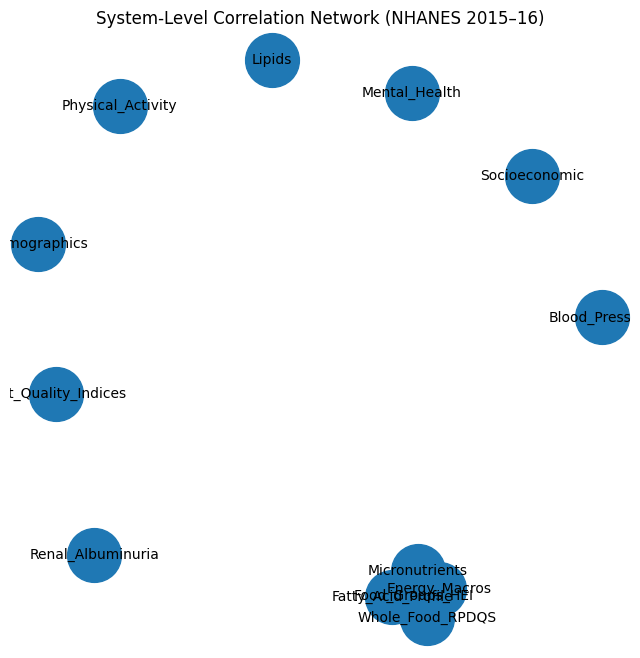

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

corr_sys = df_system.corr()

G_sys = nx.Graph()

for col in corr_sys.columns:
    G_sys.add_node(col)

THRESH = 0.3  # you can adjust

for i in corr_sys.columns:
    for j in corr_sys.columns:
        if i >= j:
            continue
        r = corr_sys.loc[i, j]
        if abs(r) > THRESH:
            G_sys.add_edge(i, j, weight=r)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_sys, seed=42)
weights = [abs(G_sys[u][v]['weight']) * 3 for u, v in G_sys.edges()]

nx.draw_networkx_nodes(G_sys, pos, node_size=1500)
nx.draw_networkx_labels(G_sys, pos, font_size=10)
nx.draw_networkx_edges(G_sys, pos, width=weights, alpha=0.7)

plt.title("System-Level Correlation Network (NHANES 2015–16)")
plt.axis("off")
plt.show()


# rebuild GGM

In [53]:
from sklearn.covariance import GraphicalLassoCV
import numpy as np

X_sys = df_system.values
names = df_system.columns

ggm = GraphicalLassoCV()
ggm.fit(X_sys)

Theta = ggm.precision_
D = np.sqrt(np.diag(Theta))

partial_corr = -Theta / np.outer(D, D)
np.fill_diagonal(partial_corr, 1.0)

partial_df = pd.DataFrame(partial_corr, index=names, columns=names)
partial_df


,Lipids,Blood_Pressure,Renal_Albuminuria,Demographics,Socioeconomic,Physical_Activity,Energy_Macros,Fatty_Acid_Profile,Micronutrients,Food_Groups_HEI,Whole_Food_RPDQS,Diet_Quality_Indices,Mental_Health
Lipids,1.000000,0.095186,-0.040838,0.188239,0.030657,-0.002226,-0.069824,0.047271,-0.001547,-0.005947,0.052899,0.015894,0.007503
Blood_Pressure,0.095186,1.000000,0.058487,0.159001,0.019668,0.060126,-0.051543,0.003871,-0.010656,0.035518,0.029678,-0.054821,0.110610
Renal_Albuminuria,-0.040838,0.058487,1.000000,-0.004234,-0.019008,0.010306,0.009774,0.018194,-0.018674,-0.001641,-0.022286,-0.048648,0.043050
Demographics,0.188239,0.159001,-0.004234,1.000000,0.051419,0.032892,-0.085853,0.003668,-0.035367,0.046332,0.032643,0.083999,0.188872
Socioeconomic,0.030657,0.019668,-0.019008,0.051419,1.000000,-0.031419,-0.006089,-0.011959,-0.001019,0.003774,0.030364,0.022754,-0.072552
Physical_Activity,-0.002226,0.060126,0.010306,0.032892,-0.031419,1.000000,0.034671,-0.036242,-0.002096,-0.000000,-0.021322,-0.023020,0.059697
Energy_Macros,-0.069824,-0.051543,0.009774,-0.085853,-0.006089,0.034671,1.000000,0.428692,0.218600,0.423602,0.052118,-0.137642,0.042517
Fatty_Acid_Profile,0.047271,0.003871,0.018194,0.003668,-0.011959,-0.036242,0.428692,1.000000,-0.016717,0.073671,0.052134,-0.174843,-0.031744
Micronutrients,-0.001547,-0.010656,-0.018674,-0.035367,-0.001019,-0.002096,0.218600,-0.016717,1.000000,0.243716,0.158499,0.098839,-0.011298
Food_Groups_HEI,-0.005947,0.035518,-0.001641,0.046332,0.003774,-0.000000,0.423602,0.073671,0.243716,1.000000,0.561615,0.094130,0.008307


# plot

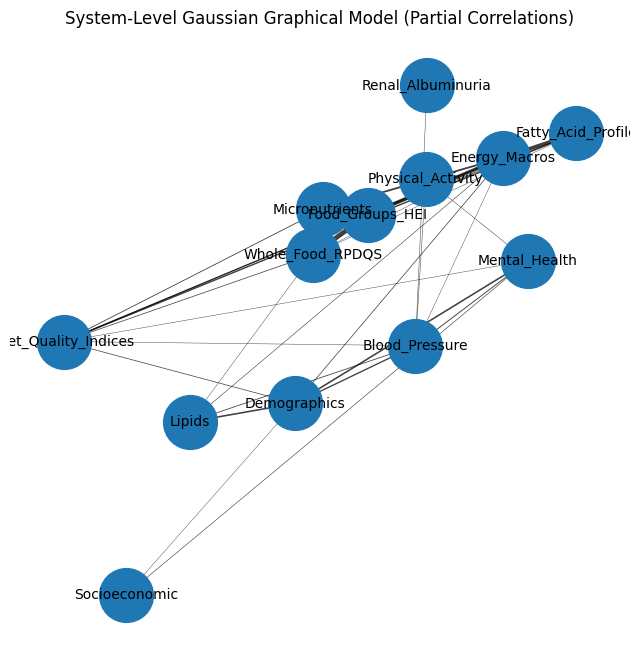

In [54]:
G_ggm = nx.Graph()
THRESH_PCOR = 0.05  # small edges removed for clarity

for i, a in enumerate(names):
    for j, b in enumerate(names):
        if i >= j:
            continue
        r = partial_corr[i, j]
        if abs(r) > THRESH_PCOR:
            G_ggm.add_edge(a, b, weight=r)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_ggm, seed=1)
weights = [abs(G_ggm[u][v]['weight']) * 6 for u, v in G_ggm.edges()]

nx.draw_networkx_nodes(G_ggm, pos, node_size=1500)
nx.draw_networkx_labels(G_ggm, pos, font_size=10)
nx.draw_networkx_edges(G_ggm, pos, width=weights, alpha=0.75)

plt.title("System-Level Gaussian Graphical Model (Partial Correlations)")
plt.axis("off")
plt.show()


# build a better plot

/var/folders/qp/44xx9pgd1_7c2_fs4jl3hf4h0000gn/T/ipykernel_90275/2119234678.py:70: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(
/var/folders/qp/44xx9pgd1_7c2_fs4jl3hf4h0000gn/T/ipykernel_90275/2119234678.py:80: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


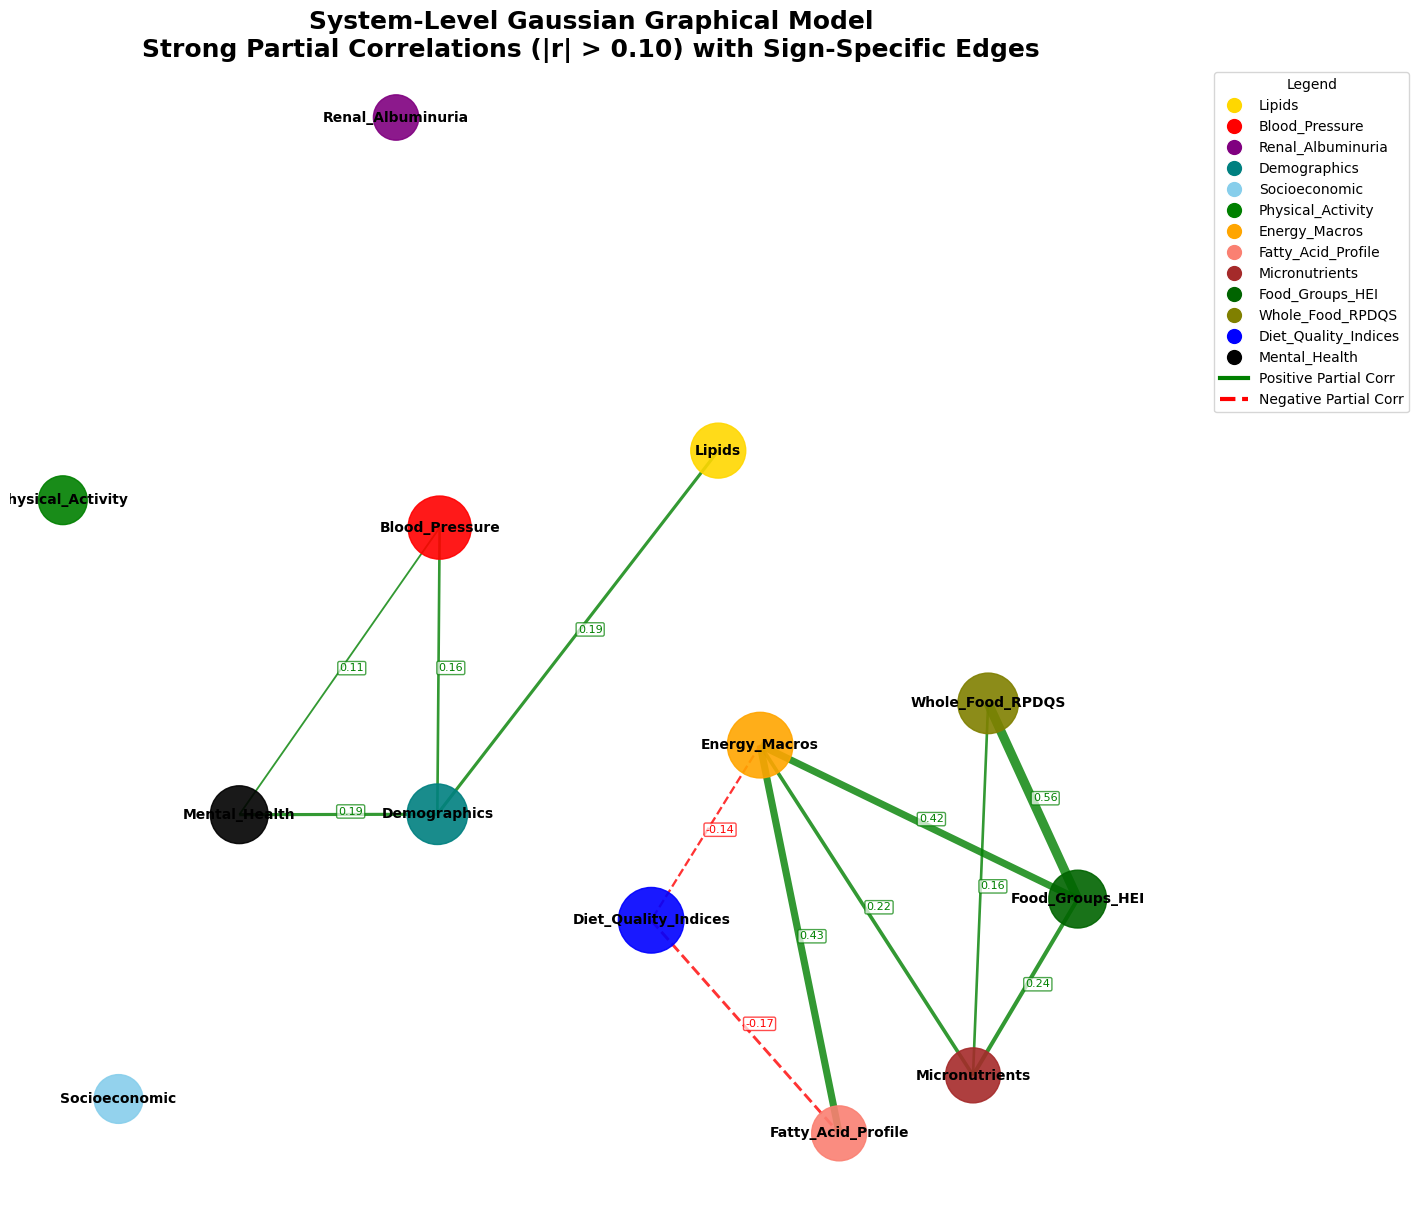

In [60]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.lines import Line2D

# ----------------------------------------------------------
# 1. COLOR MAP — must match your physio_systems dictionary
# ----------------------------------------------------------
color_map = {
    "Lipids": "gold",
    "Blood_Pressure": "red",
    "Renal_Albuminuria": "purple",
    "Demographics": "teal",
    "Socioeconomic": "skyblue",
    "Physical_Activity": "green",
    "Energy_Macros": "orange",
    "Fatty_Acid_Profile": "salmon",
    "Micronutrients": "brown",
    "Food_Groups_HEI": "darkgreen",
    "Whole_Food_RPDQS": "olive",
    "Diet_Quality_Indices": "blue",
    "Mental_Health": "black"
}

node_colors = [color_map.get(node, "gray") for node in G_ggm.nodes()]

# ----------------------------------------------------------
# 2. NODE SIZES: scaled by degree centrality
# ----------------------------------------------------------
centrality = nx.degree_centrality(G_ggm)
node_sizes = [2000 * centrality[node] + 900 for node in G_ggm.nodes()]

# ----------------------------------------------------------
# 3. LAYOUT — ignore weights to avoid negative-weight bug
# ----------------------------------------------------------
pos = nx.kamada_kawai_layout(G_ggm, weight=None)

# ----------------------------------------------------------
# 4. DRAW NODES
# ----------------------------------------------------------
plt.figure(figsize=(15, 15))

nx.draw_networkx_nodes(
    G_ggm, pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.9
)

# ----------------------------------------------------------
# 5. FILTER EDGES: keep only |partial corr| > 0.10
# ----------------------------------------------------------
filtered_edges = [
    (u, v) for u, v in G_ggm.edges()
    if abs(G_ggm[u][v]['weight']) > 0.10
]

positive_edges = [(u, v) for u, v in filtered_edges if G_ggm[u][v]['weight'] > 0]
negative_edges = [(u, v) for u, v in filtered_edges if G_ggm[u][v]['weight'] < 0]

# Edge widths (scaled by strength)
edge_widths_pos = [abs(G_ggm[u][v]['weight']) * 12 for u, v in positive_edges]
edge_widths_neg = [abs(G_ggm[u][v]['weight']) * 12 for u, v in negative_edges]

# ----------------------------------------------------------
# 6. DRAW EDGES (curved + sign-specific)
# ----------------------------------------------------------

# Positive edges: green, solid, curved right
nx.draw_networkx_edges(
    G_ggm, pos,
    edgelist=positive_edges,
    width=edge_widths_pos,
    edge_color='green',
    alpha=0.8,
    connectionstyle="arc3,rad=0.12"
)

# Negative edges: red, dashed, curved left
nx.draw_networkx_edges(
    G_ggm, pos,
    edgelist=negative_edges,
    width=edge_widths_neg,
    edge_color='red',
    alpha=0.8,
    style='dashed',
    connectionstyle="arc3,rad=-0.12"
)

# ----------------------------------------------------------
# 7. LABELS ON NODES
# ----------------------------------------------------------
nx.draw_networkx_labels(
    G_ggm, pos,
    font_size=10,
    font_weight="bold"
)

# ----------------------------------------------------------
# 8. EDGE LABELS — color-matched to sign
# ----------------------------------------------------------
edge_label_dict = {
    (u, v): f"{G_ggm[u][v]['weight']:.2f}"
    for u, v in filtered_edges
}

for (u, v), label in edge_label_dict.items():
    x, y = (pos[u] + pos[v]) / 2
    color = "green" if G_ggm[u][v]['weight'] > 0 else "red"

    plt.text(
        x, y, label,
        fontsize=8,
        color=color,
        bbox=dict(
            facecolor="white",
            edgecolor=color,
            boxstyle="round,pad=0.15",
            alpha=0.7
        )
    )

# ----------------------------------------------------------
# 9. LEGEND — node colors + edge types
# ----------------------------------------------------------
legend_nodes = [
    Line2D([0], [0], marker='o', color='w', label=system,
           markerfacecolor=color, markersize=12)
    for system, color in color_map.items()
]

legend_edges = [
    Line2D([0], [0], color='green', lw=3, label='Positive Partial Corr'),
    Line2D([0], [0], color='red',   lw=3, label='Negative Partial Corr', linestyle='dashed')
]

plt.legend(
    handles=legend_nodes + legend_edges,
    loc='upper left',
    bbox_to_anchor=(1.03, 1.0),
    title="Legend",
    frameon=True,
    fontsize=10
)

# ----------------------------------------------------------
# 10. TITLE
# ----------------------------------------------------------
plt.title(
    "System-Level Gaussian Graphical Model\n"
    "Strong Partial Correlations (|r| > 0.10) with Sign-Specific Edges",
    fontsize=18, weight="bold"
)

plt.axis("off")
plt.show()



# making more balanced (some of the nutritional heaviness was due to more data in diet domain)

/var/folders/qp/44xx9pgd1_7c2_fs4jl3hf4h0000gn/T/ipykernel_90275/921986103.py:141: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(
/var/folders/qp/44xx9pgd1_7c2_fs4jl3hf4h0000gn/T/ipykernel_90275/921986103.py:151: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


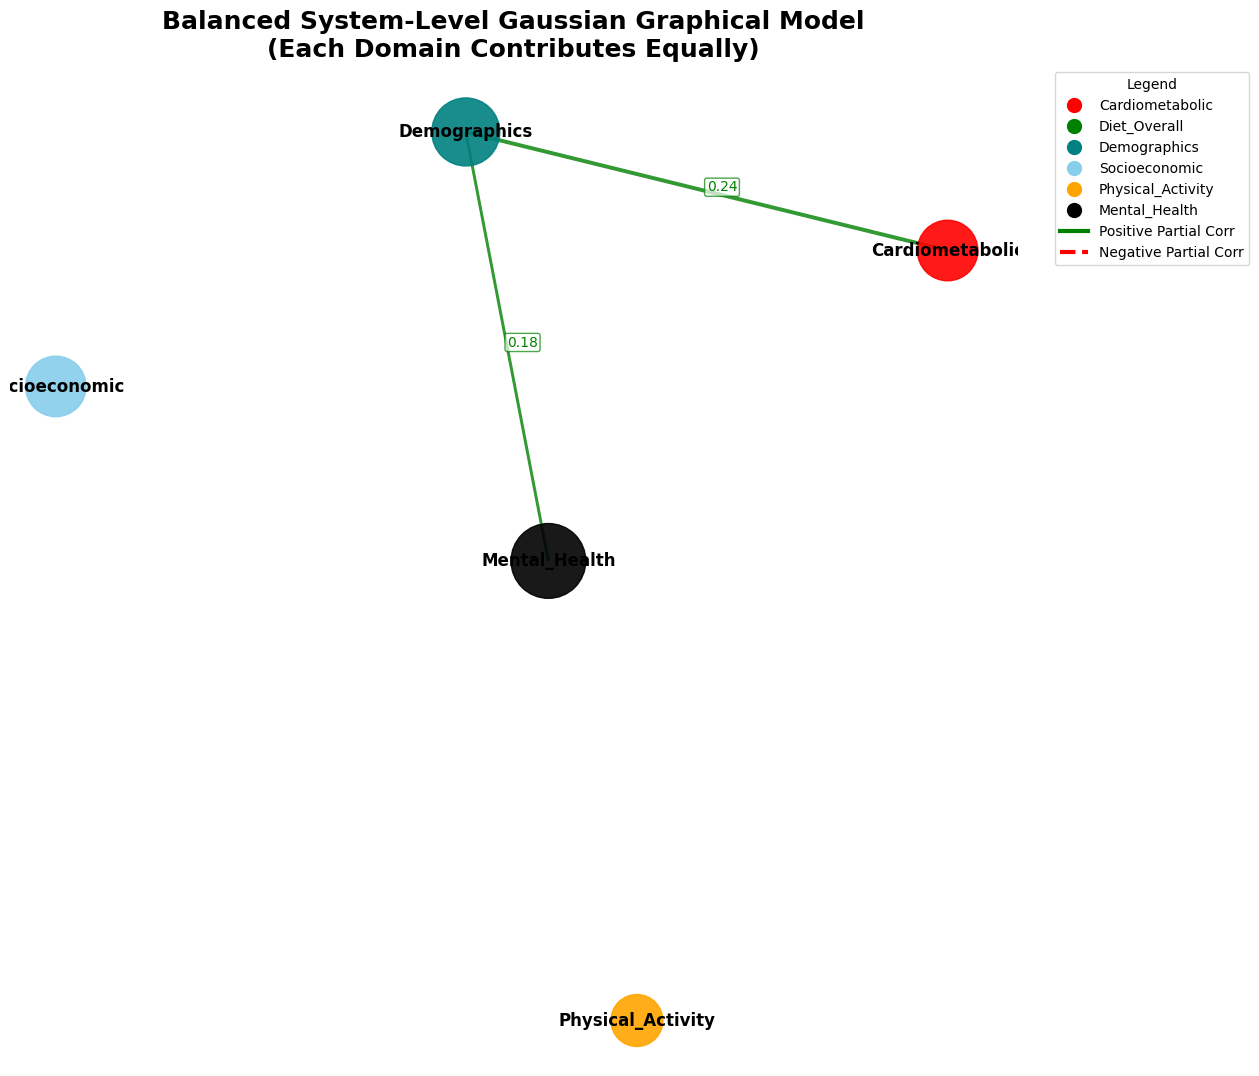

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLassoCV

# ==========================================================
# 0. df_system MUST already exist from your earlier pipeline
# ==========================================================

# ----------------------------------------------------------
# 1. Balanced domain definitions (each ~1 node)
# ----------------------------------------------------------
balanced_domains = {
    "Cardiometabolic": [
        "Lipids",
        "Blood_Pressure",
        "Renal_Albuminuria"
    ],
    "Diet_Overall": [
        "Energy_Macros",
        "Fatty_Acid_Profile",
        "Micronutrients",
        "Food_Groups_HEI",
        "Whole_Food_RPDQS",
        "Diet_Quality_Indices"
    ],
    "Demographics": ["Demographics"],
    "Socioeconomic": ["Socioeconomic"],
    "Physical_Activity": ["Physical_Activity"],
    "Mental_Health": ["Mental_Health"]
}

# ----------------------------------------------------------
# 2. Build balanced domain-level dataframe
# ----------------------------------------------------------
df_balanced = pd.DataFrame(index=df_system.index)

for dom, cols in balanced_domains.items():
    valid = [c for c in cols if c in df_system.columns]
    if len(valid) == 0:
        continue
    df_balanced[dom] = df_system[valid].mean(axis=1)

# ----------------------------------------------------------
# 3. Standardize each domain so all domains contribute equally
# ----------------------------------------------------------
scaler_bal = StandardScaler()
df_balanced_z = pd.DataFrame(
    scaler_bal.fit_transform(df_balanced),
    columns=df_balanced.columns,
    index=df_balanced.index
)

# ----------------------------------------------------------
# 4. Fit Graphical LASSO on balanced domains
# ----------------------------------------------------------
X_bal = df_balanced_z.values
names_bal = df_balanced_z.columns

ggm_bal = GraphicalLassoCV()
ggm_bal.fit(X_bal)

Theta_bal = ggm_bal.precision_
D_bal = np.sqrt(np.diag(Theta_bal))

# Partial correlation matrix
partial_corr_bal = -Theta_bal / np.outer(D_bal, D_bal)
np.fill_diagonal(partial_corr_bal, 1.0)

partial_df_bal = pd.DataFrame(
    partial_corr_bal,
    index=names_bal,
    columns=names_bal
)

# ----------------------------------------------------------
# 5. Build GGM graph (threshold edges)
# ----------------------------------------------------------
G_ggm_bal = nx.Graph()

THRESH = 0.05

for i, a in enumerate(names_bal):
    for j, b in enumerate(names_bal):
        if i >= j:
            continue
        r = partial_corr_bal[i, j]
        if abs(r) > THRESH:
            G_ggm_bal.add_edge(a, b, weight=r)

# ----------------------------------------------------------
# 6. Color map for balanced domains
# ----------------------------------------------------------
color_map_bal = {
    "Cardiometabolic": "red",
    "Diet_Overall": "green",
    "Demographics": "teal",
    "Socioeconomic": "skyblue",
    "Physical_Activity": "orange",
    "Mental_Health": "black"
}

node_colors_bal = [color_map_bal.get(node, "gray") for node in G_ggm_bal.nodes()]

centrality_bal = nx.degree_centrality(G_ggm_bal)
node_sizes_bal = [2000 * centrality_bal[node] + 900 for node in G_ggm_bal.nodes()]

# ----------------------------------------------------------
# 7. Layout (ignore weights)
# ----------------------------------------------------------
pos_bal = nx.kamada_kawai_layout(G_ggm_bal, weight=None)

# ----------------------------------------------------------
# 8. Begin plotting
# ----------------------------------------------------------
plt.figure(figsize=(13, 13))

nx.draw_networkx_nodes(
    G_ggm_bal, pos_bal,
    node_color=node_colors_bal,
    node_size=node_sizes_bal,
    alpha=0.9
)

# ----------------------------------------------------------
# 9. Filter edges |r| > 0.10 and draw them
# ----------------------------------------------------------
filtered_edges = [(u, v) for u, v in G_ggm_bal.edges()
                  if abs(G_ggm_bal[u][v]['weight']) > 0.10]

pos_edges = [(u, v) for u, v in filtered_edges if G_ggm_bal[u][v]['weight'] > 0]
neg_edges = [(u, v) for u, v in filtered_edges if G_ggm_bal[u][v]['weight'] < 0]

w_pos = [abs(G_ggm_bal[u][v]['weight']) * 12 for u, v in pos_edges]
w_neg = [abs(G_ggm_bal[u][v]['weight']) * 12 for u, v in neg_edges]

# Positive edges: solid green, curved right
nx.draw_networkx_edges(
    G_ggm_bal, pos_bal,
    edgelist=pos_edges,
    width=w_pos,
    edge_color='green',
    alpha=0.8,
    connectionstyle="arc3,rad=0.12"
)

# Negative edges: dashed red, curved left
nx.draw_networkx_edges(
    G_ggm_bal, pos_bal,
    edgelist=neg_edges,
    width=w_neg,
    edge_color='red',
    alpha=0.8,
    style='dashed',
    connectionstyle="arc3,rad=-0.12"
)

# ----------------------------------------------------------
# 10. Node labels
# ----------------------------------------------------------
nx.draw_networkx_labels(
    G_ggm_bal, pos_bal,
    font_size=12,
    font_weight="bold"
)

# ----------------------------------------------------------
# 11. Edge labels (color matched)
# ----------------------------------------------------------
for (u, v) in filtered_edges:
    x, y = (pos_bal[u] + pos_bal[v]) / 2
    r = G_ggm_bal[u][v]['weight']
    color = "green" if r > 0 else "red"
    plt.text(
        x, y, f"{r:.2f}",
        fontsize=10,
        color=color,
        bbox=dict(
            facecolor="white",
            edgecolor=color,
            boxstyle="round,pad=0.15",
            alpha=0.7
        )
    )

# ----------------------------------------------------------
# 12. Legend
# ----------------------------------------------------------
legend_nodes = [
    Line2D([0], [0], marker='o', color='w', label=dom,
           markerfacecolor=color, markersize=12)
    for dom, color in color_map_bal.items()
]

legend_edges = [
    Line2D([0], [0], color='green', lw=3, label='Positive Partial Corr'),
    Line2D([0], [0], color='red', lw=3, label='Negative Partial Corr', linestyle='dashed')
]

plt.legend(
    handles=legend_nodes + legend_edges,
    loc='upper left',
    bbox_to_anchor=(1.03, 1.0),
    title="Legend",
    frameon=True,
    fontsize=10
)

plt.title(
    "Balanced System-Level Gaussian Graphical Model\n(Each Domain Contributes Equally)",
    fontsize=18, weight="bold"
)

plt.axis("off")
plt.savefig("balanced_network.png", dpi=300, bbox_inches="tight")
plt.show()


### **Interpretation of the Balanced System-Level Network**

The balanced version of the network reduces all diet variables to a single “Diet_Overall” node and combines the cardiometabolic markers into one “Cardiometabolic” node. This ensures each physiologic domain contributes roughly equal information.

In this balanced model, only two edges remain after graphical lasso regularization:

1. **Demographics → Cardiometabolic (partial r = 0.24)**
   This reflects well-established relationships between demographic factors (age, sex, race/ethnicity, poverty ratio) and cardiometabolic outcomes. These demographic variables strongly determine blood pressure, lipid levels, and kidney function. This connection is expected and represents a genuine physiological pattern.

2. **Demographics → Mental Health (partial r = 0.18)**
   Mental health scores also have a direct association with demographic characteristics. Age and sex strongly influence PHQ-9 scores, and socioeconomic factors embedded within demographic variables contribute to population-level differences in mental health.

All other domains—Diet_Overall, Socioeconomic, and Physical_Activity—show no surviving edges once the model is balanced. This suggests that once demographics are accounted for, these domains do not provide additional independent explanatory power in this reduced framework.

This result is important:

* In the original, unbalanced network, diet appeared central largely because it contained many more underlying variables than other systems.
* After balancing each domain so they each contribute the same amount of information, diet no longer appears as a central physiologic driver.
* This tells us that the dominance of diet in the original network was partly driven by measurement density and strong internal correlations within the dietary variables, rather than by diet exerting uniquely strong independent physiologic effects across domains.

In summary, the balanced network reveals a simpler structure where demographics directly influence both cardiometabolic health and mental health, while other domains appear conditionally independent after adjusting for these factors.

# semi balanced network

/var/folders/qp/44xx9pgd1_7c2_fs4jl3hf4h0000gn/T/ipykernel_90275/1057228930.py:148: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(
/var/folders/qp/44xx9pgd1_7c2_fs4jl3hf4h0000gn/T/ipykernel_90275/1057228930.py:157: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


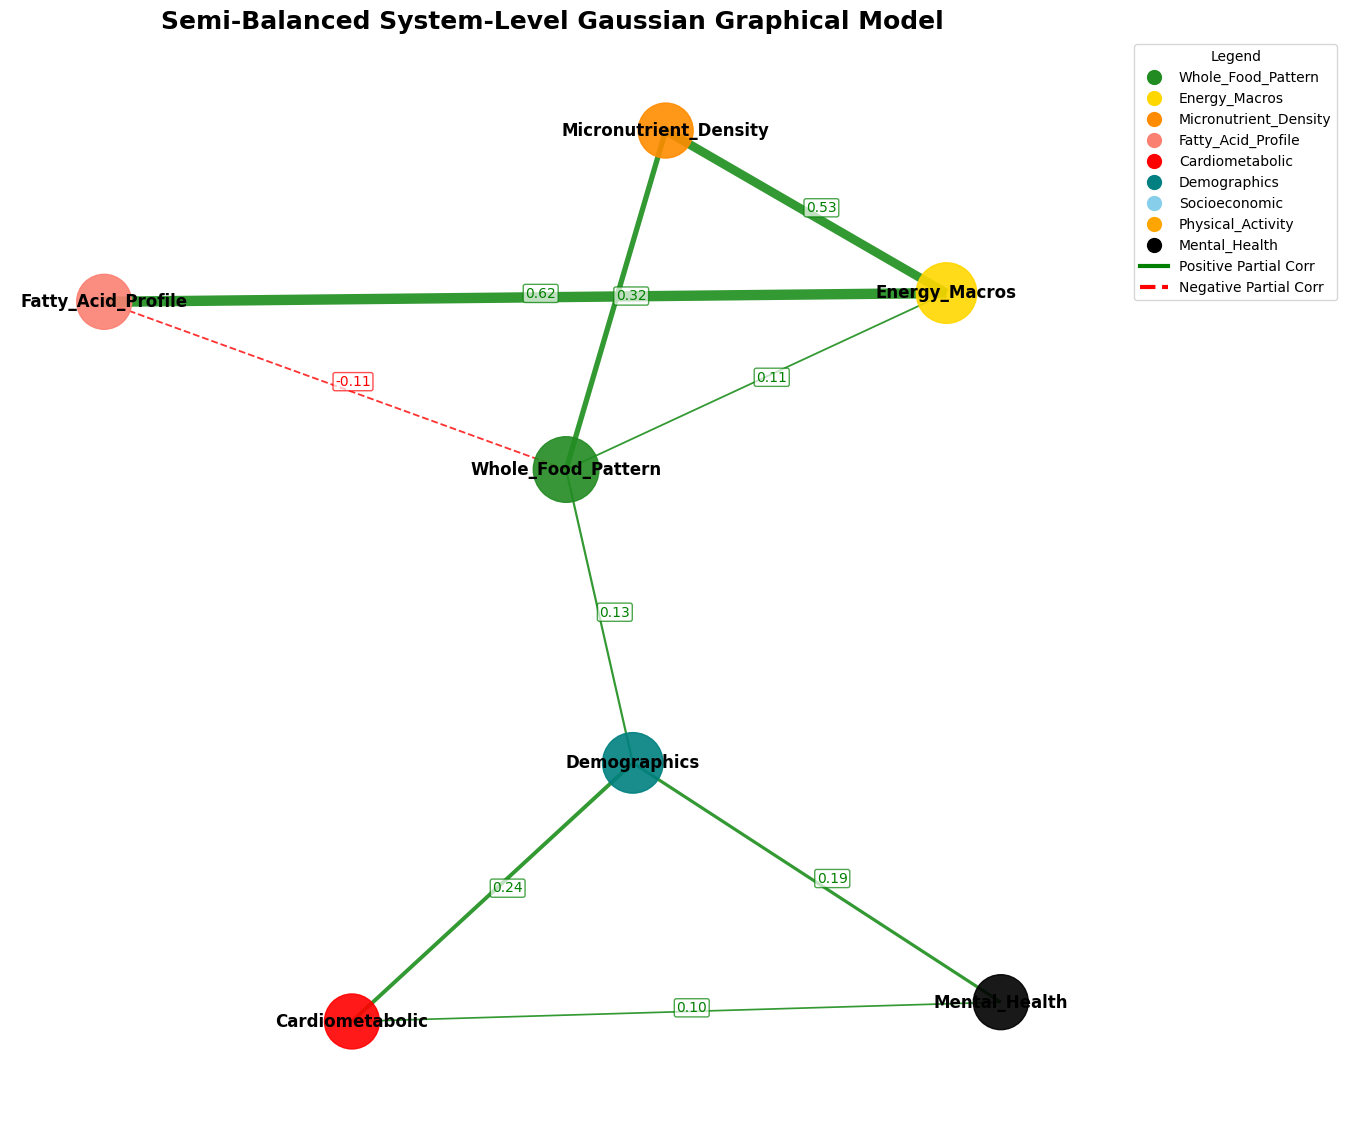

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLassoCV

# ==========================================================
# df_system should already exist (the system-level dataframe)
# ==========================================================

# ----------------------------------------------------------
# 1. Semi-balanced domain structure
#    Diet represented by 3–4 physiologically meaningful nodes
# ----------------------------------------------------------
semi_balanced_domains = {
    "Whole_Food_Pattern": [
        "Whole_Food_RPDQS",
        "Food_Groups_HEI",
        "Diet_Quality_Indices"
    ],
    "Energy_Macros": [
        "Energy_Macros"
    ],
    "Micronutrient_Density": [
        "Micronutrients"
    ],
    "Fatty_Acid_Profile": [
        "Fatty_Acid_Profile"
    ],
    
    "Cardiometabolic": [
        "Lipids",
        "Blood_Pressure",
        "Renal_Albuminuria"
    ],
    "Demographics": [
        "Demographics"
    ],
    "Socioeconomic": [
        "Socioeconomic"
    ],
    "Physical_Activity": [
        "Physical_Activity"
    ],
    "Mental_Health": [
        "Mental_Health"
    ]
}

# ----------------------------------------------------------
# 2. Build semi-balanced domain dataset
# ----------------------------------------------------------
df_semi = pd.DataFrame(index=df_system.index)

for dom, cols in semi_balanced_domains.items():
    valid = [c for c in cols if c in df_system.columns]
    if len(valid) > 0:
        df_semi[dom] = df_system[valid].mean(axis=1)

# ----------------------------------------------------------
# 3. Standardize domains
# ----------------------------------------------------------
scaler = StandardScaler()
df_semi_z = pd.DataFrame(
    scaler.fit_transform(df_semi),
    columns=df_semi.columns,
    index=df_semi.index
)

# ----------------------------------------------------------
# 4. Fit GGM using Graphical LASSO
# ----------------------------------------------------------
names = df_semi_z.columns
X = df_semi_z.values

ggm = GraphicalLassoCV()
ggm.fit(X)

Theta = ggm.precision_
D = np.sqrt(np.diag(Theta))
partial_corr = -Theta / np.outer(D, D)
np.fill_diagonal(partial_corr, 1.0)

partial_df_semi = pd.DataFrame(partial_corr, index=names, columns=names)

# ----------------------------------------------------------
# 5. Build GGM graph (threshold edges)
# ----------------------------------------------------------
G_semi = nx.Graph()
THRESH = 0.10

for i, a in enumerate(names):
    for j, b in enumerate(names):
        if i >= j:
            continue
        r = partial_corr[i, j]
        if abs(r) > THRESH:
            G_semi.add_edge(a, b, weight=r)

# ----------------------------------------------------------
# 6. Color map
# ----------------------------------------------------------
color_map = {
    "Whole_Food_Pattern": "forestgreen",
    "Energy_Macros": "gold",
    "Micronutrient_Density": "darkorange",
    "Fatty_Acid_Profile": "salmon",
    
    "Cardiometabolic": "red",
    "Demographics": "teal",
    "Socioeconomic": "skyblue",
    "Physical_Activity": "orange",
    "Mental_Health": "black"
}

node_colors = [color_map.get(node, "gray") for node in G_semi.nodes()]
centrality = nx.degree_centrality(G_semi)
node_sizes = [2000 * centrality[node] + 900 for node in G_semi.nodes()]

# ----------------------------------------------------------
# 7. Layout
# ----------------------------------------------------------
pos = nx.kamada_kawai_layout(G_semi, weight=None)

# ----------------------------------------------------------
# 8. Plot
# ----------------------------------------------------------
plt.figure(figsize=(14, 14))

nx.draw_networkx_nodes(
    G_semi, pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.9
)

# ----------------------------------------------------------
# 9. Sign-specific edges
# ----------------------------------------------------------
pos_edges = [(u, v) for u, v in G_semi.edges() if G_semi[u][v]['weight'] > 0]
neg_edges = [(u, v) for u, v in G_semi.edges() if G_semi[u][v]['weight'] < 0]

w_pos = [abs(G_semi[u][v]['weight']) * 12 for u, v in pos_edges]
w_neg = [abs(G_semi[u][v]['weight']) * 12 for u, v in neg_edges]

nx.draw_networkx_edges(
    G_semi, pos,
    edgelist=pos_edges,
    width=w_pos,
    edge_color='green',
    alpha=0.8,
    connectionstyle="arc3,rad=0.12"
)

nx.draw_networkx_edges(
    G_semi, pos,
    edgelist=neg_edges,
    width=w_neg,
    edge_color='red',
    alpha=0.8,
    style='dashed',
    connectionstyle="arc3,rad=-0.12"
)

# ----------------------------------------------------------
# 10. Labels
# ----------------------------------------------------------
nx.draw_networkx_labels(G_semi, pos, font_size=12, font_weight="bold")

# Edge labels
for (u, v) in G_semi.edges():
    x, y = (pos[u] + pos[v]) / 2
    r = G_semi[u][v]['weight']
    c = "green" if r > 0 else "red"
    plt.text(
        x, y, f"{r:.2f}",
        fontsize=10,
        color=c,
        bbox=dict(facecolor="white",
                  edgecolor=c,
                  boxstyle="round,pad=0.15",
                  alpha=0.7)
    )

# ----------------------------------------------------------
# 11. Legend
# ----------------------------------------------------------
legend_nodes = [
    Line2D([0], [0], marker='o', color='w', label=dom,
           markerfacecolor=color, markersize=12)
    for dom, color in color_map.items()
]

legend_edges = [
    Line2D([0], [0], color='green', lw=3, label='Positive Partial Corr'),
    Line2D([0], [0], color='red', lw=3, label='Negative Partial Corr', linestyle='dashed')
]

plt.legend(
    handles=legend_nodes + legend_edges,
    loc='upper left',
    bbox_to_anchor=(1.03, 1.0),
    title="Legend",
    frameon=True,
    fontsize=10
)

plt.title("Semi-Balanced System-Level Gaussian Graphical Model", fontsize=18, weight="bold")
plt.axis("off")
plt.savefig("semi_balanced.png", dpi=300, bbox_inches="tight")
plt.show()


### **Interpretation of the Semi-Balanced Network**

The semi-balanced model keeps diet variables grouped into meaningful subsystems while preventing diet from numerically overwhelming the network. This produces a clearer picture of how diet, physiology, and demographics relate to one another.

#### **1. Strong linkage between Energy Macros and Fatty Acid Profile**

* These two domains show the strongest positive partial correlation (≈0.62).
* This reflects shared physiological meaning: macronutrient intake is tightly tied to fatty acid consumption patterns.

#### **2. Micronutrient Density is strongly coordinated with Energy Macros**

* The partial correlation (≈0.53) indicates that individuals with higher energy intake quality also tend to consume more nutrient-dense foods.
* This suggests a coherent “diet quality cluster.”

#### **3. Whole Food Pattern connects diet quality to demographics**

* Whole Food Pattern shows moderate positive associations with both:

  * Demographics (≈0.13)
  * Energy Macros (≈0.11)
* This implies that whole-food consumption is shaped by demographic factors (age, sex, race/ethnicity) and also linked to overall energy intake structure.

#### **4. Fatty Acid Profile negatively relates to Whole Food Pattern**

* A weak but meaningful negative partial correlation (≈−0.11).
* This suggests that whole-food–oriented eating patterns may shift the fatty acid composition away from less healthy profiles.

#### **5. Classic demographic pathways remain intact**

* Demographics → Cardiometabolic (≈0.24)
* Demographics → Mental Health (≈0.19)
* These connections reproduce well-known gradients between population characteristics, metabolic health, and psychological wellness.

#### **6. Mental Health and Cardiometabolic health are directly related**

* A small positive partial correlation (≈0.10), consistent with shared lifestyle and biological mediators (e.g., inflammation, sleep, socioeconomic stress).

#### **7. Socioeconomic and Physical Activity remain isolated**

* In this slice of NHANES data, after partialling out all other domains:

  * Socioeconomic indicators show no remaining strong direct edges.
  * Physical Activity is also disconnected.
* This typically reflects measurement sparsity or higher confounding across domains.
